In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 


from random import sample

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score 
from sklearn import metrics 


%matplotlib inline

random_state = 42

In [16]:
# Read in the data 
df = pd.read_csv('employee_retention.csv', index_col=0) 
# if there is no header, then set header = None 
# index_col = 0 drop the first column 

In [17]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


In [72]:
print(df[df.duplicated(subset=['employee_id'])])
#if there is duplicates, keep the first and drop the rest 
df.drop_duplicates(subset=['employee_id'],keep='first',inplace=True)

Empty DataFrame
Columns: [employee_id, company_id, dept, seniority, salary, join_date, quit_date, status]
Index: []


In [4]:
#df.drop(columns = df.columns[0], inplace=True)

In [73]:
df.info() # for viewing the datatype 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24461 entries, 1 to 34701
Data columns (total 8 columns):
employee_id    24461 non-null int64
company_id     24461 non-null int64
dept           24461 non-null category
seniority      24461 non-null int64
salary         24461 non-null float64
join_date      24461 non-null datetime64[ns]
quit_date      13377 non-null datetime64[ns]
status         24461 non-null int64
dtypes: category(1), datetime64[ns](2), float64(1), int64(4)
memory usage: 1.5 MB


In [74]:
# Fix the datatype
df['employee_id'] = df.employee_id.astype(int)
df['dept'] = df.dept.astype('category')

In [75]:
df.describe() # descriptive statistics 

,employee_id,company_id,seniority,salary,status
count,24461.000000,24461.000000,24461.000000,24461.000000,24461.000000
mean,501641.147745,3.425862,14.125220,138195.862802,0.546871
std,288911.204749,2.699708,8.055002,76058.515210,0.497808
min,36.000000,1.000000,1.000000,17000.000000,0.000000
25%,250315.000000,1.000000,7.000000,79000.000000,0.000000
50%,501134.000000,2.000000,14.000000,123000.000000,1.000000
75%,753061.000000,5.000000,21.000000,187000.000000,1.000000
max,999969.000000,12.000000,29.000000,408000.000000,1.000000


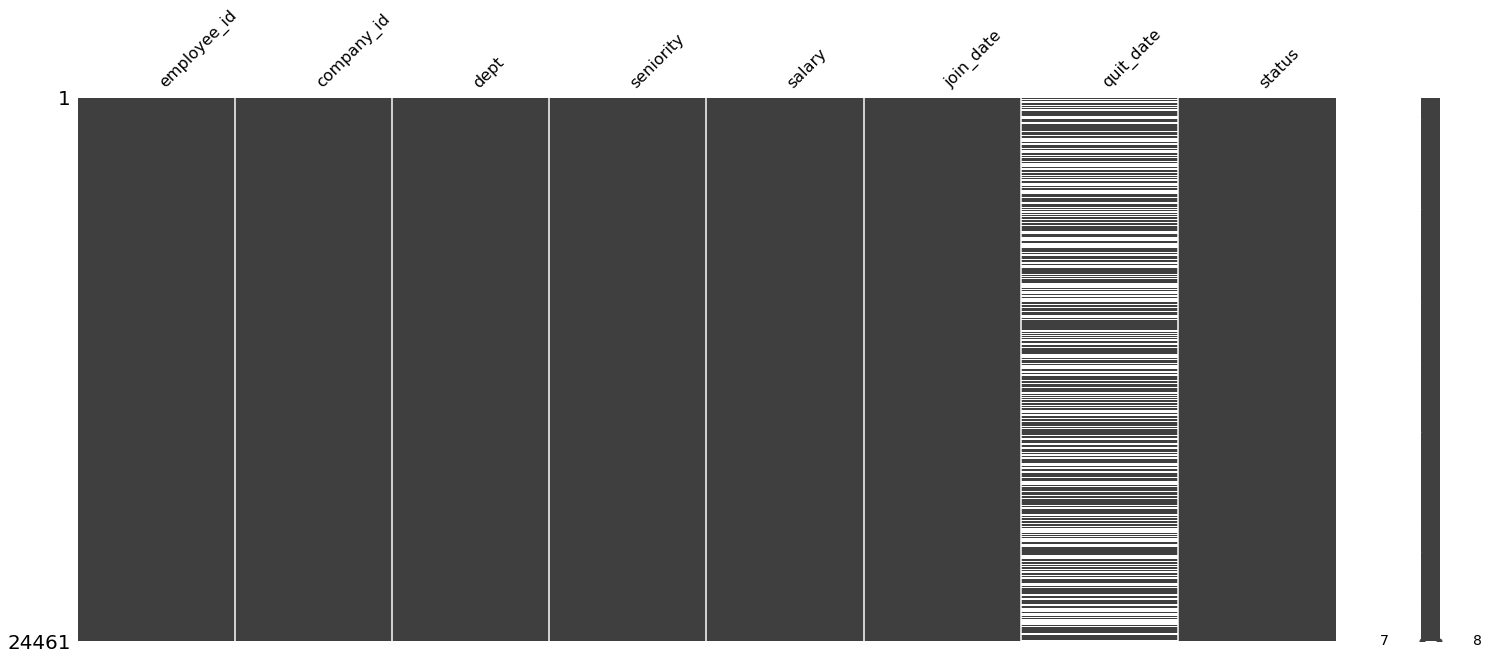

In [76]:
import missingno 
missingno.matrix(df)

In [19]:
# count how many missing values for each variable
df.apply(lambda x: sum(x.isnull()), axis=0)

employee_id        0
company_id         0
dept               0
seniority          0
salary           239
join_date          0
quit_date      11192
dtype: int64

In [80]:
df.dropna(axis=0,subset=['salary'],inplace=True) 
#axis = 0 indicating droping on the row
# or df = df.dropna(subset=['salary'])

In [20]:
# sanity checks on the data
print(df['dept'].unique())
# this all seems to be in order - maybe make a distribution to see how things look
df = df[df['dept']!='temp_contractor']


# drop salaries that are missing (just a few) and also drop the impossibly high seniorities. 
df = df[df['seniority'] < 95]

[temp_contractor, design, engineer, marketing, customer_service, data_science, sales]
Categories (7, object): [temp_contractor, design, engineer, marketing, customer_service, data_science, sales]


In [21]:
# encode dept categories 
dept_cat = {'design': 1, 'engineer': 2, 'marketing': 3, 'customer_service': 4, 
            'data_science':5, 'sales':6}
df['dept'].replace(dept_cat, inplace=True)

In [22]:
# fix the datetimes - recast the 05.08.2014 etc as standard 2014-08-05
df['join_date'] = df['join_date'].str.replace('.', '-')
df['join_date'] = pd.to_datetime(df['join_date'])

df['quit_date'] = df['quit_date'].str.replace('.', '-')
df['quit_date'] = pd.to_datetime(df['quit_date'])

In [13]:
print('minimum date', df['join_date'].min())
print('maximum date', df['join_date'].max())

minimum date 2007-01-01 00:00:00
maximum date 2015-12-10 00:00:00


In [23]:
df = df[df['join_date']>=pd.to_datetime('2011/01/04')]
df = df[df['join_date']<=pd.to_datetime('2015/12/23')]

In [24]:
df.loc[df['quit_date'].isnull(), 'status'] = 0
df.loc[df['quit_date'].notnull(), 'status'] = 1

In [25]:
df['status'] = df.status.astype(int)

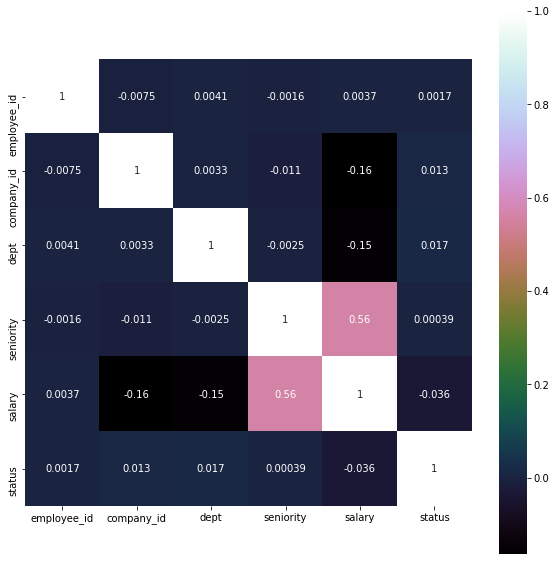

In [26]:
# Check for correlations in the data
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

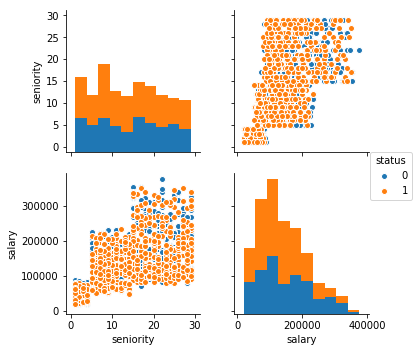

In [27]:
# take a 5% sample as this is computationally expensive 
df_sample = df.sample(frac=0.05)
# pairwise plots 
pplot = sns.pairplot(df_sample, vars=["seniority", "salary"], hue = "status")

#### This is not used in this dataset but worth knowing skills 

Salary has 3 values low, medium and high. These factor variables have an order. I'm going to go use dummy encoding as a simple and common method to handle factor variables. The downsides to this is I am not handling the ordering and will introduce extra dimensions to the data (see Curse of dimensionality for why this is bad). Helmert, Forward/Backward differencing or Orthogonal encoding would probably be better.

>>> df.salary.unique()

#array(['low', 'medium', 'high'], dtype=object)  
>>> df.sales.unique()
#array(['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD'], dtype=object) 


# Dummy Encoding
Dummy encoding, or one hot encoding, transforms categorical variables into a series of binary columns. Before I one hot encode the sales and salary I prepend the column names to the categories, that way I know later which column each new column came from. This helps particularly in cases where the columns use the same category names e.g. 'high' could apply to sales and salary.

#Prepend string prior to encoding
# df['salary'] = '$_' + df['salary'].astype(str)  
# df['sales'] = 'sales_' + df['sales'].astype(str)

#Create 'salary' dummies and join
# one_hot_salary = pd.get_dummies(df['salary'])  
# df = df.join(one_hot_salary)

#Create 'sales' dummies and join
# one_hot_sales = pd.get_dummies(df['sales'])  
# df = df.join(one_hot_sales) 


#If we proceeded to modelling without dropping columns, we would run into the dummy variable trap. To illustrate what the dummy variable trap is, let's say that our data has a column for Gender in the form ['male','female','male','female'...]. If we use pd.get_dummies()


#Generate 'Gender' variable
# Gender = np.random.choice(['male','female'], 4)  
#Create DataFrame
# df1 = pd.DataFrame(Gender, columns=['Gender'])  
#One hot encode Gender
# dummies = pd.get_dummies(df1['Gender'])  
#Join dummies to 'df1'
# df1 = df1.join(dummies)  
#print df1  
   Gender  female  male
0    male       0     1  
1  female       1     0  
2    male       0     1  
3  female       1     0  

We can see that the dummy columns of female and male reflect the Gender column, a row with column Gender='male' has female=0 and male=1. In modelling, we are looking for independent variables to predict a dependent outcome. One of our dummy variables is completely dependent on the other (see Multicollinearity). We can naturally drop one of the dummy variables to avoid this trap whilst not losing any valuable information.

To avoid the dummy variable trap in the Kaggle HR dataset, I'm dropping the columns, sales_IT and low salary $_low.
#Drop unnecessary columns to avoid the dummy variable trap

# df = df.drop(['salary', 'sales', '$_low', 'sales_IT'], axis=1) 

### Split Into Test and Training Sets
Now to split the dataset up into our training, testing and optionally our validation sets. This is best done randomly to avoid having one subgroup of the data overrepresented in either our training or testing datasets, hence df.sample().

In [54]:
# Randomly, split the data into test/training/validation sets
#train, test, validate = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])  
#print(train.shape, test.shape, validate.shape)
# (8999, 20) (3000, 20) (3000, 20)
X = df.drop(['status','join_date','quit_date'], axis=1) 
y = df['status']
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.33,
                                                    random_state=42)

# Separate target and predictors
y_train = train['status']  
x_train = train.drop(['status','join_date','quit_date'], axis=1)  
y_test = test['status']  
x_test = test.drop(['status','join_date','quit_date'], axis=1)  
y_validate = validate['status']  
x_validate = validate.drop(['status','join_date','quit_date'], axis=1)

In [55]:
x_train.head()

,employee_id,company_id,dept,seniority,salary
34269,68275,2,2,1,70000.0
12691,741023,6,6,18,178000.0
22125,724973,3,3,20,181000.0
10135,460035,5,6,6,112000.0
14518,811518,3,4,8,64000.0


In [56]:
# Check the balance of the splits on y_
y_test.mean()

0.5357364053016227

In [57]:
y_train.mean()

0.55235538198681966

# Feature importance can be ascertained from a random forest, alternatively Principle Components Analysis (PCA) can be used.

In [58]:
# Variable importance
rf = RandomForestClassifier()  
rf.fit(x_train, y_train)  
print("Features sorted by their score:")  
print(sorted(zip(map(lambda x: round(x, 4), 
                     rf.feature_importances_), 
                     x_train), reverse=True))

Features sorted by their score:
[(0.41289999999999999, 'employee_id'), (0.29830000000000001, 'salary'), (0.16569999999999999, 'seniority'), (0.087499999999999994, 'company_id'), (0.0356, 'dept')]


In [60]:
# Variable importance revealed that only the first 4 variables explained 
# most of the variance. Therefore, only 4 variables are used. 
# Create variable lists and drop
all_vars = x_train.columns.tolist()  
top_4_vars = ['employee_id', 'salary', 'seniority', 'company_id']  
bottom_vars = [cols for cols in all_vars if cols not in top_4_vars]

# Drop less important variables leaving the top_4
x_train    = x_train.drop(bottom_vars, axis=1)  
x_test     = x_test.drop(bottom_vars, axis=1)  
#x_validate = x_validate.drop(bottom_vars, axis=1)  

In [61]:
x_train.head()

,employee_id,company_id,seniority,salary
34269,68275,2,1,70000.0
12691,741023,6,18,178000.0
22125,724973,3,20,181000.0
10135,460035,5,6,112000.0
14518,811518,3,8,64000.0


In [62]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Modeling
## 1.logistic regression 

In [63]:
# Instantiate
logit_model = LogisticRegression()  
# Fit
logit_model = logit_model.fit(x_train, y_train)  
# How accurate?
logit_model.score(x_train, y_train)  
#0.7874

# Predictions on the test dataset
predicted = pd.DataFrame(logit_model.predict(x_test))  
# Probabilities on the test dataset
probs = pd.DataFrame(logit_model.predict_proba(x_test))  
print(metrics.accuracy_score(y_test, predicted)) 


# How does it perform on the test dataset?
logit_accuracy = metrics.accuracy_score(y_test, predicted)  
logit_roc_auc = metrics.roc_auc_score(y_test, probs[1])  
logit_confus_matrix = metrics.confusion_matrix(y_test, predicted)  
logit_classification_report = metrics.classification_report(y_test, predicted)  
logit_precision = metrics.precision_score(y_test, predicted, pos_label=1)  
logit_recall = metrics.recall_score(y_test, predicted, pos_label=1)  
logit_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

0.538833147529


## Now let's look at the confusion matrix and the metrics we care about.

In [ ]:
print(metrics.confusion_matrix(y_test, predicted))

In [ ]:
print(metrics.classification_report(y_test, predicted))

## 2. Decision Tree
Decision trees are highly interpretable and tend to perform well on classification problems.

## 3. Random Forest

In [64]:
# Instantiate
rf = RandomForestClassifier()  
# Fit
rf_model = rf.fit(x_train, y_train)  
# training accuracy 99.74%
rf_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(rf_model.predict(x_test))  
probs = pd.DataFrame(rf_model.predict_proba(x_test))

# Store metrics
rf_accuracy = metrics.accuracy_score(y_test, predicted)  
rf_roc_auc = metrics.roc_auc_score(y_test, probs[1])  
rf_confus_matrix = metrics.confusion_matrix(y_test, predicted)  
rf_classification_report = metrics.classification_report(y_test, predicted)  
rf_precision = metrics.precision_score(y_test, predicted, pos_label=1)  
rf_recall = metrics.recall_score(y_test, predicted, pos_label=1)  
rf_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(RandomForestClassifier(), x_test, y_test, scoring='precision', cv=10)  
rf_cv_mean = np.mean(rf_cv_scores)

In [65]:
# Model comparison
models = pd.DataFrame({  
  'Model': ['Logistic', 'r.f.'],
  'Accuracy' : [logit_accuracy, rf_accuracy],
  'Precision': [logit_accuracy, rf_accuracy],
  'recall' : [logit_accuracy, rf_accuracy],
  'F1' : [logit_f1, rf_f1],
  'cv_precision' : [logit_accuracy, rf_accuracy]
})

In [66]:
# Print table and sort by test precision
models.sort_values(by='Precision', ascending=False)

,Model,Accuracy,Precision,recall,F1,cv_precision
0,Logistic,0.538833,0.538833,0.538833,0.696404,0.538833
1,r.f.,0.514802,0.514802,0.514802,0.542994,0.514802


### From the above results table, it is clear the Random Forest is the best model based on Accuracy, Precision and Recall metrics. The performance is so good, that I would be concerned about overfitting and a lack of generalisation to future periods of data. However, the classifier was evaluated with K-folds cross-validation (K=10) and also evaluated on the test dataset.

To use the trained model later, it's first best practice to re-train on the entire dataset to get the best trained model. Then save the pickle i.e. serialised model.

In [67]:
# Create x and y from all data
y = df['status'] 
x = df.drop(['status','join_date','quit_date'], axis=1)


scaler = StandardScaler()
x = scaler.fit_transform(x)


# Re-train model on all data
rf_model = rf.fit(x, y)

# Save model
from sklearn.externals import joblib 
# persist the model 
joblib.dump(rf_model, 'churn_classifier.pkl')

['churn_classifier.pkl']

In [ ]:
logit_model = 